<a href="https://www.kaggle.com/code/owaiskhan9654/utilizing-biobert-for-pico-evidence-summarization?scriptVersionId=105797656" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Utilizing BioBERT for PICO Evidence Summarization for Medical Literature  related to Heart Disease💔</div>
<br>
<center><h1 style = "font-size:20px;font-family: Comic Sans MS"> There is lot of confusion out there related to <b> Evidence Based PICO Classification tasks.</b> </h1></center>
<br>
<center><h1 style = "font-size:20px;font-family: Comic Sans MS"> 
In this Notebook I have demonstrated a simple yet effective way to utilize transformer BIO BERT Model and have an end to end pipeline with training to its live deployment.</h1></center>
<br>

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">There is a lot of improvements required in this and that why each single feedback matters. Feel free to comment if you have any queries:)</h1></center>
<br>

### Model Deployed [Link](https://huggingface.co/spaces/owaiskha9654/PICO-Evidence-Based-Classification-Inference)

<img src="https://raw.githubusercontent.com/Owaiskhan9654/Utilizing-BioBERT-for-PICO-Evidence-Summarization/main/Logo%20Medical%20Literature%20%20related%20to%20heart%20disease%202.JPG">


- In this work, I have utilized the dataset from the paper published in IEEE Journal of Biomedical and Health Informatics
 [Aceso: PICO-Guided Evidence Summarization on Medical Literature](https://ieeexplore.ieee.org/document/9056501)


- There are other sets of PICO datasets utilized in there work but I have utilized only Heart Disease Medical Literature sentences**. 

- Dataset have been processed and proper Tags labelling has been done before utiizing the Data in this notebook 

- Each sentence in a given clinical publication is classified into four labels: **P, I/C, O and N**. 

- Here combination of the element "C" with the element "I" has been done in this dataset, because a “comparison” usually concerns with one or more ”intervention” in an randomized controlled trial (RCT). These two elements are usually intertwined and indistinguishable at the sentence level. 

- The label N stands for sentences that are not relevant to the evidence.

<br>

### This Notebook is Created by [**Owais Ahmad**](https://www.linkedin.com/in/owaiskhan9654/) for training of BioBERT model on a PICO Evidence Summarization on Medical Literature articles related to Heart Disease💔.
### Disclaimer- This is for Medical Research Purpose only.
 
 
 
- **Email owaiskhan9654@gmail.com**
- **Contact +919515884381**
<br>
<br>

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

> I have integrated W&B for visualizations and logging artifacts!
> 
> [PICO Evidence Summarization](https://wandb.ai/bminelytics-research-lab/BIOBERT%20NER%20on%20CORD19?workspace=user-owaiskhan9515)


> 
> - To get the API key, create an account in the [website](https://wandb.ai/site) .
> - Use secrets to use API Keys more securely 

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Libraries/Packages Imports</div>

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from kaggle_secrets import UserSecretsClient
from sklearn.model_selection import train_test_split

import wandb
import torch
import spacy
from spacy import displacy
nlp = spacy.blank('en')
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [2]:
try:
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
    
    
wandb.init(project="PICO Evidence Summarization",name=f"11.PICO Evidence Summarization BioBert-Base-Cased-v1.2-Run 11")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: owaiskhan9515. Use `wandb login --relogin` to force relogin


In [3]:
df=pd.read_csv('../input/pico-medical-literatures-related-to-heart-disease/PICO_Tags_Heart_Disease_Semi_Processed.csv')
df

,Sentences,Tags
0,methods total 107 women clinical indication in...,Population/Problem (element P)
1,patients her2 hr positive mbc labc randomized ...,Intervention and Comparison (element I and C)
2,statistical significance defined p-value 0 05,Not Relevant to the Evidence (Label N)
3,exclusion criteria included nephrotic proteinu...,Population/Problem (element P)
4,radial artery cannulation performed summarise ...,Intervention and Comparison (element I and C)
...,...,...
2692,crying grimacing reduced 82% 65% control infan...,Outcome (element O)
2693,design setting tobacco exercise diet messages ...,Population/Problem (element P)
2694,twenty-four-h holter recordings two-channel re...,Intervention and Comparison (element I and C)
2695,patients assigned bmsc control restricted rand...,Intervention and Comparison (element I and C)


In [4]:
df['Tags'].value_counts()

Intervention and Comparison (element I and C)    760
Outcome (element O)                              653
Not Relevant to the Evidence (Label N)           648
Population/Problem (element P)                   636
Name: Tags, dtype: int64

In [5]:
evidence_labels = df.Tags.unique()

evidence_dict = {}
for index, evidence_labels in enumerate(evidence_labels):
    evidence_dict[evidence_labels] = index
evidence_dict

{'Population/Problem (element P)': 0,
 'Intervention and Comparison (element I and C)': 1,
 'Not Relevant to the Evidence (Label N)': 2,
 'Outcome (element O)': 3}

In [6]:
df['Tags Mapped'] = df.Tags.map(evidence_dict)
df

,Sentences,Tags,Tags Mapped
0,methods total 107 women clinical indication in...,Population/Problem (element P),0
1,patients her2 hr positive mbc labc randomized ...,Intervention and Comparison (element I and C),1
2,statistical significance defined p-value 0 05,Not Relevant to the Evidence (Label N),2
3,exclusion criteria included nephrotic proteinu...,Population/Problem (element P),0
4,radial artery cannulation performed summarise ...,Intervention and Comparison (element I and C),1
...,...,...,...
2692,crying grimacing reduced 82% 65% control infan...,Outcome (element O),3
2693,design setting tobacco exercise diet messages ...,Population/Problem (element P),0
2694,twenty-four-h holter recordings two-channel re...,Intervention and Comparison (element I and C),1
2695,patients assigned bmsc control restricted rand...,Intervention and Comparison (element I and C),1


In [7]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,\
                                                  df['Tags Mapped'].values,\
                                                  test_size=0.15,\
                                                  random_state=42,\
                                                  stratify=df['Tags Mapped'].values)

In [8]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [9]:
df.groupby(['Tags', 'Tags Mapped', 'data_type']).count()

Sentences
Tags                                          Tags Mapped data_type           
Intervention and Comparison (element I and C) 1           train            646
                                                          val              114
Not Relevant to the Evidence (Label N)        2           train            551
                                                          val               97
Outcome (element O)                           3           train            555
                                                          val               98
Population/Problem (element P)                0           train            540
                                                          val               96

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Loading Tokenizer of Biobert DMIS LAB</div>
<br>
  


In [10]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True,truncation=True)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

In [11]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Sentences.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    truncation=True,
    padding='longest', 
    max_length=512, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Sentences.values, 
    add_special_tokens=True, 
    truncation=True,
    return_attention_mask=True, 
    padding='longest', 
    max_length=512, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
tags_train = torch.tensor(df[df.data_type=='train']['Tags Mapped'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
tags_val = torch.tensor(df[df.data_type=='val']['Tags Mapped'].values)

In [12]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, tags_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, tags_val)

In [13]:
print(len(dataset_train), len(dataset_val))

2292 405


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Loading Pretrained Weights of Biobert DMIS LAB for finetuning it on our own task</div>
<br>
  


In [14]:
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2",
                                                      num_labels=len(evidence_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [15]:
batch_size = 16 #Defining Batch Size on which model has to be trained

# Converting tensors Dataset to dataloaders so that model can be trained
dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train), batch_size=batch_size) 

dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [16]:
optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8) # Initializing Adam Weight Decay Optimizer with its parameters 

In [17]:
epochs = 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)

In [18]:
def f1_score_func(preds, tags):
    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()
    return f1_score(tags_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, tags):
    evidence_dict_inverse = {v: k for k, v in evidence_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()

    for tag in np.unique(tags_flat):
        y_preds = preds_flat[tags_flat==tag]
        y_true = tags_flat[tags_flat==tag]
        print(f'PICO Evidence Class: {evidence_dict_inverse[tag]}')
        print(f'Accuracy: {len(y_preds[y_preds==tag])}/{len(y_true)}\n')

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Setting Seeds values for Results regenerations</div>

In [19]:
seed_val = 199
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Pushing Model to device GPU if available else CPU</div>

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">A custom evaluation method to test the performance of the model</div>

In [21]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [22]:
!mkdir models #creating Directory for model storing

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Training starts here</div>
<br>
  


In [23]:
loss_train_avg_list = []
val_loss_list = []
val_f1_list = []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    torch.save(model.state_dict(), f'models/finetuned_BioBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)
    wandb.log({"Training loss":loss_train_avg, "Validation loss":val_loss,"F1 validation Score (Weighted)":val_f1,})


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1052093683845468
Validation loss: 0.7233275736753757
F1 validation Score (Weighted): 0.7931290010325743


Epoch 2:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6151222851541307
Validation loss: 0.4848881816634765
F1 validation Score (Weighted): 0.8414563572640628


Epoch 3:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3984096199274063
Validation loss: 0.45988754670207316
F1 validation Score (Weighted): 0.8314006848407541


Epoch 4:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.27972440607845783
Validation loss: 0.44964761716815144
F1 validation Score (Weighted): 0.8540741079684218


Epoch 5:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.19715692058929968
Validation loss: 0.4671402361530524
F1 validation Score (Weighted): 0.8681834827159076


Epoch 6:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.15287014485026398
Validation loss: 0.4998691620735022
F1 validation Score (Weighted): 0.8494393695910099


Epoch 7:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.11726035746202494
Validation loss: 0.5247831479288064
F1 validation Score (Weighted): 0.8635196872636867


Epoch 8:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.09586461473696141
Validation loss: 0.5497923924659307
F1 validation Score (Weighted): 0.8607337046326899


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Storing the model weights for later use</div>

In [24]:
model.load_state_dict(torch.load('models/finetuned_BioBERT_epoch_8.model', map_location=torch.device('cuda')))

<All keys matched successfully>

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Different performance metrics to evaluate the performance of model training and evaluation</div>

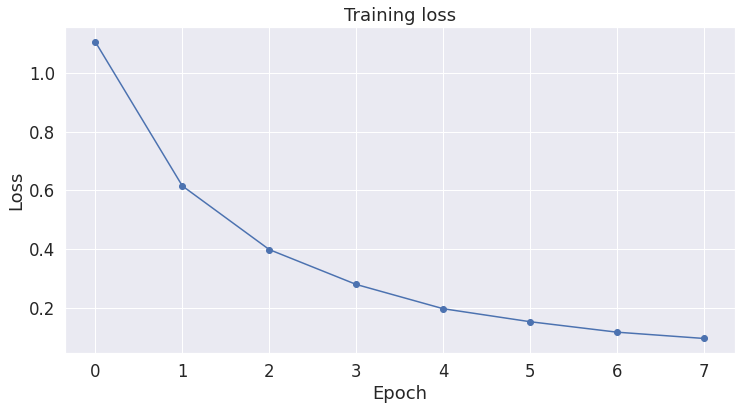

In [25]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(loss_train_avg_list, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

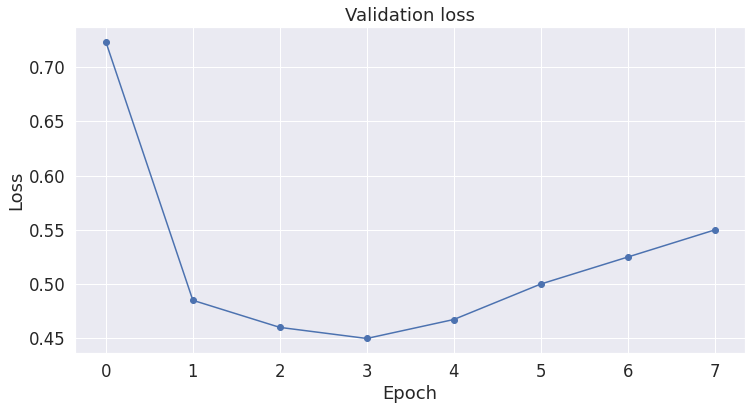

In [26]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(val_loss_list, 'b-o')

plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

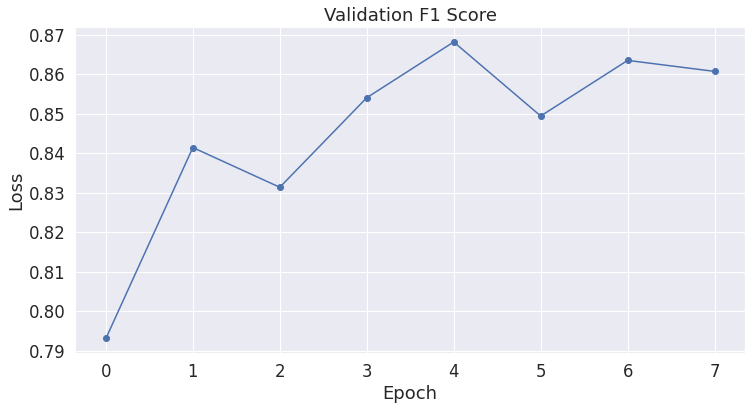

In [27]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(val_f1_list, 'b-o')

plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [28]:
wandb.finish()

F1 validation Score (Weighted),▁▆▅▇█▆█▇
Training loss,█▅▃▂▂▁▁▁
Validation loss,█▂▁▁▁▂▃▄
F1 validation Score (Weighted),0.86073
Training loss,0.09586
Validation loss,0.54979


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Checking the model performance per PICO class</div>

In [29]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [30]:
accuracy_per_class(predictions, true_vals)

PICO Evidence Class: Population/Problem (element P)
Accuracy: 84/96

PICO Evidence Class: Intervention and Comparison (element I and C)
Accuracy: 89/114

PICO Evidence Class: Not Relevant to the Evidence (Label N)
Accuracy: 92/97

PICO Evidence Class: Outcome (element O)
Accuracy: 84/98



# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Pushing Model to HuggingFace Hub for Inference</div>

In [31]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Hugging_Face_model_Push_Secret") ##Has kept it private. Please use your own token

In [32]:
!sudo apt-get install git-lfs #installing Git LFS as big model requires these to be pushed into HuggingFace Repository
!git lfs install




The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 1s (3450 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 108827 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [33]:
model.push_to_hub(repo_path_or_name='owaiskha9654/PICO_Evidence_Classification_Model',use_auth_token=secret_value_0)

/opt/conda/lib/python3.7/site-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='PICO_Evidence_Classification_Model' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/owaiskha9654/PICO_Evidence_Classification_Model into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.53k/413M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/413M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 32.0k/413M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/owaiskha9654/PICO_Evidence_Classification_Model
   0b4dde2..04d5784  main -> main



'https://huggingface.co/owaiskha9654/PICO_Evidence_Classification_Model/commit/04d57843af53da46e9f82b9e166a3fbc6e5e6200'

In [34]:
tokenizer.push_to_hub(repo_path_or_name='owaiskha9654/PICO_Evidence_Classification_Model',use_auth_token=secret_value_0)

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">References</div>


- [Aceso: PICO-Guided Evidence Summarization on Medical Literature](https://ieeexplore.ieee.org/abstract/document/9056501)

- [PICO Element Detection in Medical Text via Long Short-Term Memory Neural Networks](https://aclanthology.org/W18-2308/)

- [PubMed PICO Element Detection Dataset](https://github.com/jind11/PubMed-PICO-Detection)

- [Evidence based medicine: what it is and what it isn't](https://pubmed.ncbi.nlm.nih.gov/8555924/)

- [Why AdamW Optemizer matters](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)

<center><h1 style = "font-size:20px;font-family: Comic Sans MS"> 
In this Notebook I have demonstrated a simple yet effective way to utilize transformer BIO BERT Model and have an end to end pipeline with training to its live deployment.</h1></center>
<br>

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">There has a lot of improvements and that each single feedback matters. Feel free to comment if you have any queries:)</h1></center>

<br>

### Model Deployed [Link](https://huggingface.co/spaces/owaiskha9654/PICO-Evidence-Based-Classification-Inference)